`라이브러리 설치`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Gmarket Sans'
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('/Users/jun-seokoh/Desktop/TIL/data analysis')

from da_utils import profile, outliers, pattern

`파일 읽어오기(apt 2020 ~ 2024)`

In [2]:
df_2024 = pd.read_csv('./apt_2024.csv', encoding='EUC KR')

df_2023 = pd.read_csv('./apt_2023.csv', encoding='EUC KR')
df_2022 = pd.read_csv('./apt_2022.csv', encoding='EUC KR')
df_2021 = pd.read_csv('./apt_2021.csv', encoding='EUC KR')
df_2020 = pd.read_csv('./apt_2020.csv', encoding='EUC KR')
interest_rate = pd.read_csv('./interest.csv', encoding='UTF-8')
display(interest_rate)
df_2024.info()


,변경년도,변경월일,기준금리
0,2024,11월 28일,3.00
1,2024,10월 11일,3.25
2,2023,01월 13일,3.50
3,2022,11월 24일,3.25
4,2022,10월 12일,3.00
5,2022,08월 25일,2.50
6,2022,07월 13일,2.25
7,2022,05월 26일,1.75
8,2022,04월 14일,1.50
9,2022,01월 14일,1.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO        57458 non-null  int64  
 1   시군구       57458 non-null  object 
 2   번지        57458 non-null  object 
 3   본번        57458 non-null  int64  
 4   부번        57458 non-null  int64  
 5   단지명       57458 non-null  object 
 6   전용면적(㎡)   57458 non-null  float64
 7   계약년월      57458 non-null  int64  
 8   계약일       57458 non-null  int64  
 9   거래금액(만원)  57458 non-null  object 
 10  동         57458 non-null  object 
 11  층         57458 non-null  int64  
 12  매수자       57458 non-null  object 
 13  매도자       57458 non-null  object 
 14  건축년도      57458 non-null  int64  
 15  도로명       57458 non-null  object 
 16  해제사유발생일   57458 non-null  object 
 17  거래유형      57458 non-null  object 
 18  중개사소재지    57458 non-null  object 
 19  등기일자      57458 non-null  object 
dtypes: float64(1), int64(7), obj

`전처리 함수 생성`

In [3]:

def clean_data(df):
    # df 복사
    dfc = df.copy()
    
    # 결측치 '-' -> Na
    obj_cols = dfc.select_dtypes(include=['object']).columns
    dfc[obj_cols] = dfc[obj_cols].replace('-', pd.NA)
    
    # 1) 중복 제거
    dfc.drop_duplicates(subset=['단지명', '계약년월', '계약일','전용면적(㎡)','층','거래금액(만원)'], inplace=True)

    # 2) 해제 건 분리 보관 → df_cancel, 본데이터에서 제거
    if '해제사유발생일' in dfc.columns:
        df_cancel = dfc[dfc['해제사유발생일'].notna()].copy()
        dfc = dfc[dfc['해제사유발생일'].isna()].copy()
    else:
        df_cancel = pd.DataFrame(columns=dfc.columns)

    # 3) 계약년월+계약일 → 계약일자(datetime), 계약일 드롭
    # dfc['계약년월'] = pd.to_datetime(dfc['계약년월'].astype(str), format='%Y%m')
    ym = pd.to_datetime(dfc['계약년월'].astype(str), format='%Y%m', errors='coerce')
    day = dfc['계약일'].astype('Int64')
    dfc['계약일자'] = ym + pd.to_timedelta(day - 1, unit='D')
    dfc.drop(columns=['계약일'], inplace=True)

    # 4) 시군구 → 시/구/동 분해 후 원본 드롭
    ext = dfc['시군구'].str.extract(r'^(?P<시>\S+)\s+(?P<구>\S+)\s*(?P<동>.*)$')
    dfc[['시','구','동']] = ext[['시','구','동']]
    dfc.drop(columns=['시군구'], inplace=True)

    # 5) 거래금액(만원) → int
    dfc['거래금액(만원)'] = (
        dfc['거래금액(만원)'].astype(str)
        .str.replace(',', '', regex=False)
        # .str.replace('\u00a0', '', regex=False)
        # .str.strip()
        # .replace({'': pd.NA})
        .astype('Int64')
    )
    
    # 6) 파생: 평단가(만원) (면적 대비 비교 지표)
    dfc['평단가(만원)'] = (dfc['거래금액(만원)'].astype(float) / (dfc['전용면적(㎡)'] / 3.3)).round(2)
    
    # 7) 불필요 컬럼 드롭 (필요시 수정)
    drop_cols = ['NO','번지','본번','부번','도로명','거래유형','중개사소재지','등기일자','매수자','매도자','해제사유발생일']
    dfc.drop(columns=[c for c in drop_cols if c in dfc.columns], inplace=True, errors='ignore')

    # 8) 컬럼 정리: 최소 분석셋 우선 배치
    preferred = ['계약일자','시','구','동','전용면적(㎡)','층','건축년도','거래금액(만원)','평당가(만원)','단지명',]
    exist = [c for c in preferred if c in dfc.columns]
    others = [c for c in dfc.columns if c not in exist]
    dfc = dfc[exist + others].reset_index(drop=True)
    
    
    return dfc, df_cancel


`전처리 데이터 저장`

In [4]:
df_2024_c, df_2024_canceled  = clean_data(df_2024)
df_2023_c, df_2023_canceled  = clean_data(df_2023)
df_2022_c, df_2022_canceled  = clean_data(df_2022)
df_2021_c, df_2021_canceled  = clean_data(df_2021)
df_2020_c, df_2020_canceled  = clean_data(df_2020)


# 전처리 완료된 연도별 테이블들
dfs = [df_2020_c, df_2021_c, df_2022_c, df_2023_c, df_2024_c]

# 하나로 합치기
df_all = pd.concat(dfs, ignore_index=True)

# 연도 컬럼 추가
df_all['연도'] = df_all['계약일자'].dt.year

df_all

,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,202012,3184.28,2020
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,202012,9750.11,2020
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,202012,6998.11,2020
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,202012,1884.00,2020
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,202012,5246.11,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,202401,6464.65,2024
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,202401,5792.54,2024
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",202401,5505.51,2024
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,202401,2252.82,2024


`결측값 검증`

In [5]:
profile.get_data_profile(df_all)

# pattern.analyze_missing_patterns(df_2024_c)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 219321행 x 12열
- 메모리 사용량: 79.32mb
- 수치형 변수: 7개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),75.158,30.515,10.156,317.36,1.176,3.824,9.585,5.155
1,층,9.416,6.329,-3.000,68.00,1.223,3.081,1.833,0.032
2,건축년도,2002.037,10.608,1961.000,2024.00,-0.139,-0.372,0.389,0.028
3,거래금액(만원),100879.251,75909.569,6000.000,2500000.00,3.398,29.681,6.039,2.101
4,계약년월,202178.919,164.401,202001.000,202412.00,0.285,-1.595,0.000,0.027
5,평단가(만원),4354.816,2254.357,510.710,30115.82,1.746,4.507,5.033,51.571
6,연도,2021.727,1.642,2020.000,2024.00,0.282,-1.595,0.000,0.002



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  3.398000

- 높은 이상값 비율(>5%)
['전용면적(㎡)', '거래금액(만원)', '평단가(만원)']
--전용면적(㎡): 이상값 = 9.6%
--거래금액(만원): 이상값 = 6.0%
--평단가(만원): 이상값 = 5.0%


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),75.158,30.515,10.156,317.36,1.176,3.824,9.585,5.155
1,층,9.416,6.329,-3.000,68.00,1.223,3.081,1.833,0.032
2,건축년도,2002.037,10.608,1961.000,2024.00,-0.139,-0.372,0.389,0.028
3,거래금액(만원),100879.251,75909.569,6000.000,2500000.00,3.398,29.681,6.039,2.101
4,계약년월,202178.919,164.401,202001.000,202412.00,0.285,-1.595,0.000,0.027
5,평단가(만원),4354.816,2254.357,510.710,30115.82,1.746,4.507,5.033,51.571
6,연도,2021.727,1.642,2020.000,2024.00,0.282,-1.595,0.000,0.002


In [6]:
# _, final_ol_2024 = outliers.outlier_detection(df_2024_c)
# _, final_ol_2023 = outliers.outlier_detection(df_2023_c)
# _, final_ol_2022 = outliers.outlier_detection(df_2022_c)
# _, final_ol_2021 = outliers.outlier_detection(df_2021_c)
# _, final_ol_2020 = outliers.outlier_detection(df_2020_c)
_, apt_outliers = outliers.outlier_detection(df_all)

=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 21022개 (9.6%)
  층: 4021개 (1.8%)
  건축년도: 853개 (0.4%)
  거래금액(만원): 13244개 (6.0%)
  평단가(만원): 11038개 (5.0%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.93
 다변량 이상값: 4982개 (2.3%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 21932개 (10.0%)

 == 최종 이상값: 19767개 (9.0%)


In [7]:
df_all[apt_outliers].groupby('구').size().sort_values(ascending=False)
# 이상치가 유독 많이 분포된 지역이 인기구라, 별도의 제거 작업 수행하지 않음.

bins = [0, 60, 85, float('inf')]
labels = ['소형','중형','대형']
df_all['규모구분'] = pd.cut(df_all['전용면적(㎡)'], bins=bins, labels=labels, right=True, include_lowest=True)

df_all[apt_outliers].groupby('규모구분').size().sort_values(ascending=False)
# 역시 여기도 대형에 많이 분포됨.

# 계약년월을 datetime으로 변환
df_all['계약년월'] = pd.to_datetime(df_all['계약년월'].astype(str), format='%Y%m')

df_all

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_10699/1019133397.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all[apt_outliers].groupby('규모구분').size().sort_values(ascending=False)


,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도,규모구분
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,2020-12-01,3184.28,2020,중형
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,2020-12-01,9750.11,2020,대형
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,2020-12-01,6998.11,2020,중형
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,2020-12-01,1884.00,2020,대형
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,2020-12-01,5246.11,2020,중형
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,2024-01-01,6464.65,2024,소형
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,2024-01-01,5792.54,2024,중형
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",2024-01-01,5505.51,2024,소형
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,2024-01-01,2252.82,2024,중형


In [8]:
df_all

,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도,규모구분
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,2020-12-01,3184.28,2020,중형
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,2020-12-01,9750.11,2020,대형
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,2020-12-01,6998.11,2020,중형
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,2020-12-01,1884.00,2020,대형
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,2020-12-01,5246.11,2020,중형
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,2024-01-01,6464.65,2024,소형
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,2024-01-01,5792.54,2024,중형
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",2024-01-01,5505.51,2024,소형
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,2024-01-01,2252.82,2024,중형


### 전체 이상치의 구단위 분포

`테이블 합치기`

#### 평단가 기준 상위 지역 선별

> 평단가 기준 상위 66%를 꾸준히 들어온 지역 선발

- 강남
- 서초
- 용산
- 송파
- 성동
- 마포

In [9]:
from scipy.stats import norm

# 연도-구별 중위값
g = (
    df_all.groupby(['연도','구'])['평단가(만원)']
        .median().reset_index(name='중위값')
)

# 순위(내림차순), 백분위 퍼센티지(상위=100%)
g['순위'] = g.groupby('연도')['중위값'] \
                .rank(method='dense', ascending=False).astype(int)

g['상위(%)'] = (
    g.groupby('연도')['중위값']
     .transform(lambda x: norm.cdf((x - x.mean()) / x.std()) * 100)
).round(1)

# 연도별 (구, 중위값, 퍼센티지) 표를 만들고 인덱스를 순위로
per_year = []
for y, sub in g.groupby('연도', sort=True):
    t = (sub[['순위','구','중위값','상위(%)']]
            .sort_values(['순위','중위값'], ascending=[True, False])
            .set_index('순위'))
    t.columns = pd.MultiIndex.from_product([[y], t.columns])
    per_year.append(t)

out = pd.concat(per_year, axis=1)
out.index.name = '순위'

out

2020                  2021                  2022                  2023  \
       구       중위값 상위(%)     구       중위값 상위(%)     구       중위값 상위(%)     구   
순위                                                                           
1    강남구  7181.105  99.8   강남구  7860.290  99.5   강남구  7936.155  99.7   강남구   
2    서초구  5820.100  96.4   서초구  6811.750  96.5   서초구  6508.270  95.3   서초구   
3    용산구  5093.070  88.6   송파구  6284.250  92.2   송파구  6482.610  95.2   용산구   
4    송파구  5048.470  87.9   용산구  6110.230  90.1   용산구  6191.370  92.6   송파구   
5    성동구  4678.120  80.7   성동구  5785.000  85.1   성동구  5777.890  87.2   성동구   
6    광진구  4375.055  73.3   광진구  5246.730  73.7   마포구  4936.400  69.6   마포구   
7    마포구  4343.890  72.4   마포구  5127.230  70.7   광진구  4703.010  63.3   광진구   
8    동작구  3905.000  59.4   동작구  4775.405  61.0   동작구  4481.055  57.0   양천구   
9   영등포구  3743.740  54.2   강동구  4708.895  59.0   강동구  4260.560  50.5   강동구   
10   강동구  3679.050  52.1  영등포구  4466.910  51.8  영등포구  3945.480  41.2   동작구   
11    중구  3648.150  51.1    중구  4340.805  48.0  서대문구  3872.970  39.1  영등포구   
12   양천구  3321.230  40.6   양천구  4076.950  40.2   양천구  3859.650  38.8    중구   
13  서대문구  3295.010  39.8  서대문구  4064.925  39.8    중구  3813.840  37.5   종로구   
14   종로구  3146.560  35.2   강서구  3867.190  34.2   노원구  3743.260  35.5  서대문구   
15   강서구  3125.280  34.5   종로구  3794.700  32.2   성북구  3686.230  33.9   강서구   
16  동대문구  3101.770  33.8  동대문구  3773.240  31.6  동대문구  3566.450  30.8  동대문구   
17   성북구  2912.790  28.4   성북구  3644.005  28.3   종로구  3508.335  29.3   은평구   
18   관악구  2844.995  26.5   노원구  3618.000  27.6   관악구  3379.240  26.1   성북구   
19   은평구  2688.930  22.5   관악구  3571.920  26.4   은평구  3304.010  24.3   관악구   
20   노원구  2685.350  22.5   은평구  3367.350  21.7   강서구  3290.095  24.0   노원구   
21   구로구  2461.970  17.4   중랑구  3223.870  18.6   금천구  3184.770  21.6   구로구   
22   중랑구  2453.290  17.2   구로구  3069.230  15.7   중랑구  3125.660  20.3   중랑구   
23   강북구  2440.245  16.9   강북구  3038.780  15.1   강북구  3058.260  18.9   강북구   
24   금천구  2252.560  13.4   금천구  2780.590  11.0   도봉구  2836.120  14.8   금천구   
25   도봉구  2094.890  10.8   도봉구  2758.420  10.7   구로구  2655.980  11.9   도봉구   

                    2024                  
         중위값 상위(%)     구       중위값 상위(%)  
순위                                        
1   8552.240  99.6   강남구  9109.150  99.5  
2   7628.750  98.2   서초구  8775.630  99.1  
3   6610.890  92.6   용산구  7139.200  92.5  
4   6249.665  88.8   송파구  6344.555  83.9  
5   5340.340  73.7   성동구  5831.760  75.7  
6   5171.290  70.1   마포구  5535.610  70.2  
7   4952.090  65.0   광진구  5267.890  64.7  
8   4650.640  57.7   강동구  4814.060  54.8  
9   4647.890  57.6   동작구  4798.195  54.4  
10  4411.305  51.6    중구  4682.150  51.8  
11  4388.750  51.0  영등포구  4648.760  51.1  
12  4235.800  47.1   양천구  4620.620  50.4  
13  3946.375  39.8   종로구  4352.570  44.4  
14  3747.895  35.0  서대문구  4184.730  40.6  
15  3649.590  32.7   강서구  3769.855  31.8  
16  3573.360  31.0  동대문구  3682.800  30.1  
17  3514.055  29.6   은평구  3614.670  28.8  
18  3335.540  25.8   성북구  3429.480  25.3  
19  3242.150  23.9   관악구  3328.570  23.5  
20  3176.670  22.6   노원구  3137.600  20.3  
21  2961.340  18.7   구로구  3081.880  19.4  
22  2890.950  17.5   중랑구  2916.220  16.9  
23  2868.050  17.1   강북구  2843.990  15.9  
24  2559.740  12.6   금천구  2701.780  14.1  
25  2426.470  10.9   도봉구  2436.515  11.0

이후 인기구/비인기구 구분 컬럼 추가

In [10]:
valid_sets = []
for year in g['연도'].unique():
    valid = g.loc[(g['연도'] == year) & (g['상위(%)'] >= 66), '구']
    valid_sets.append(set(valid))

# 모든 연도에서 공통으로 만족하는 구
consistent_top = set.intersection(*valid_sets)
print(consistent_top)

df_all['인기구'] = df_all['구'].apply(lambda x: '인기구' if x in consistent_top else '비인기구')

df_all



{'용산구', '송파구', '서초구', '강남구', '마포구', '성동구'}


,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도,규모구분,인기구
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,2020-12-01,3184.28,2020,중형,비인기구
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,2020-12-01,9750.11,2020,대형,인기구
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,2020-12-01,6998.11,2020,중형,인기구
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,2020-12-01,1884.00,2020,대형,비인기구
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,2020-12-01,5246.11,2020,중형,인기구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,2024-01-01,6464.65,2024,소형,비인기구
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,2024-01-01,5792.54,2024,중형,인기구
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",2024-01-01,5505.51,2024,소형,인기구
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,2024-01-01,2252.82,2024,중형,비인기구


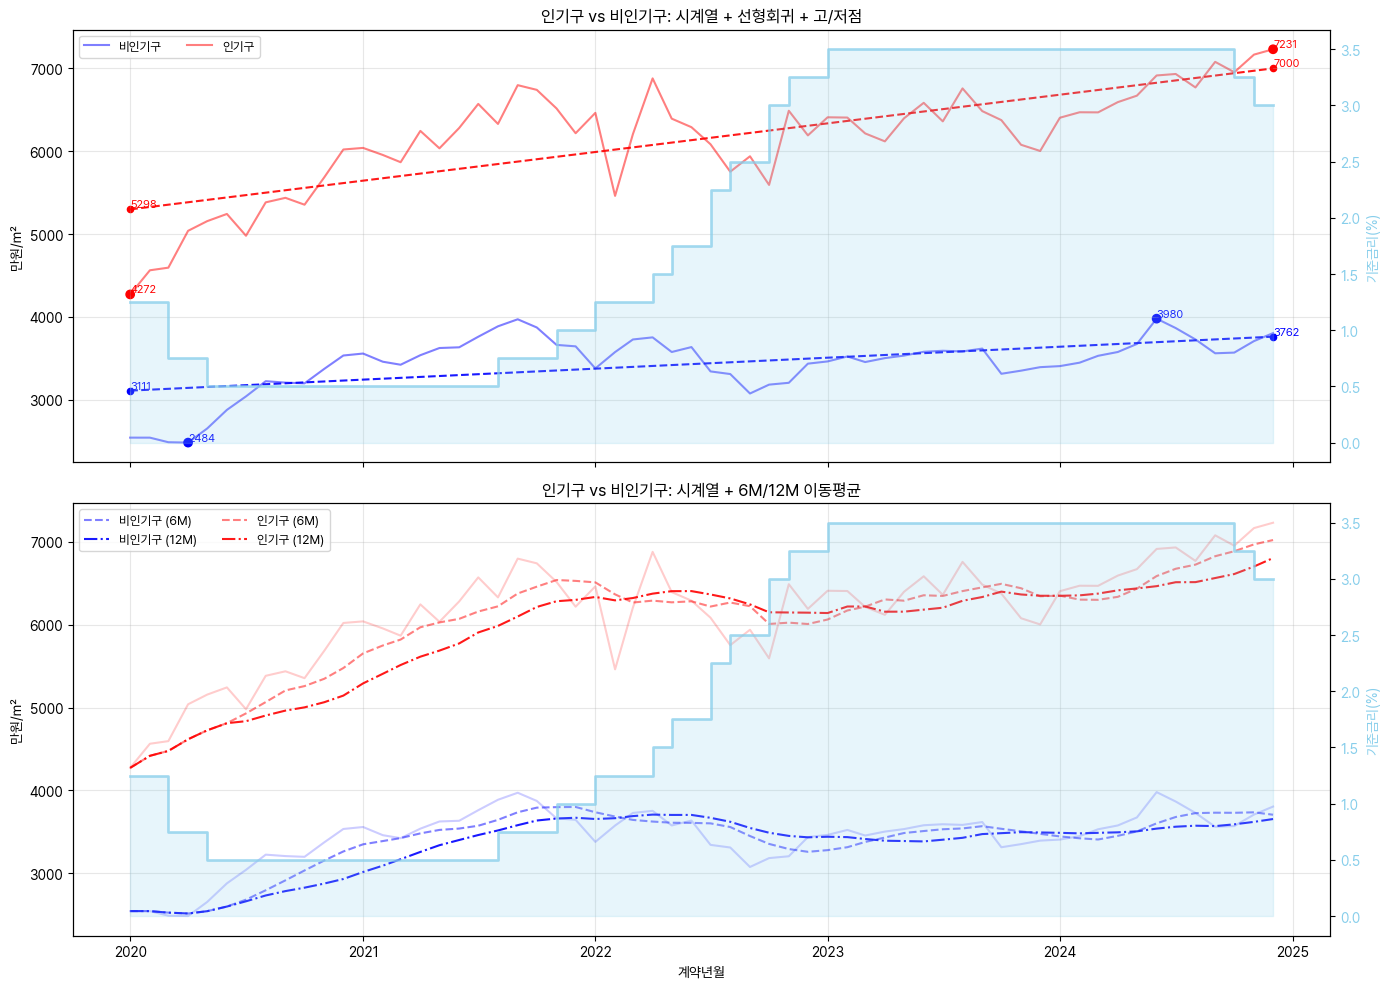

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

# 기준 금리 포함
def _parse_kor_mday(s: str):
    m = re.search(r'(\d+)월\s*(\d+)일', s)
    return int(m.group(1)), int(m.group(2))

def _rate_series_monthly(rate_csv_path, start_ts, end_ts, align_index):
    r = pd.read_csv(rate_csv_path, dtype={'변경년도':int, '변경월일':str, '기준금리':float})
    r['월'], r['일'] = zip(*r['변경월일'].map(_parse_kor_mday))
    r['변경일'] = pd.to_datetime(dict(year=r['변경년도'], month=r['월'], day=r['일']))
    r = r[['변경일','기준금리']].sort_values('변경일')
    idx_end = (pd.date_range(start=start_ts, end=end_ts, freq='MS') + pd.offsets.MonthEnd(0))
    rate = pd.merge_asof(
        pd.DataFrame({'월말': idx_end}),
        r.rename(columns={'변경일':'월말'}).sort_values('월말'),
        on='월말', direction='backward'
    )['기준금리']
    return pd.Series(rate.values, index=align_index)


# 월×인기구(0/1 or '인기구'/'비인기구') 중위값
ts = (
    df_all.groupby(['계약년월','인기구'])['평단가(만원)']
          .median().reset_index()
).sort_values('계약년월')

# 색상 매핑
color_map = {1: 'red', 0: 'blue', '인기구': 'red', '비인기구': 'blue'}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

for gval in ts['인기구'].unique():
    sub = ts[ts['인기구'] == gval].copy()
    x_dates = sub['계약년월']
    y = sub['평단가(만원)'].values
    label = "인기구" if (gval==1 or gval=="인기구") else "비인기구"
    base_color = color_map[gval]

    # 1) 시계열 + 선형회귀 + 고/저점 라벨
    ax1.plot(x_dates, y, color=base_color, alpha=0.5, label=label,)
    # 고저점
    i_max = sub['평단가(만원)'].idxmax(); x_max = sub.loc[i_max,'계약년월']; y_max = sub.loc[i_max,'평단가(만원)']
    i_min = sub['평단가(만원)'].idxmin(); x_min = sub.loc[i_min,'계약년월']; y_min = sub.loc[i_min,'평단가(만원)']
    ax1.scatter([x_max, x_min], [y_max, y_min], c=[base_color, base_color], marker='o')
    ax1.text(x_max, y_max, f"{y_max:.0f}", color=base_color, fontsize=8, va='bottom')
    ax1.text(x_min, y_min, f"{y_min:.0f}", color=base_color, fontsize=8, va='bottom')
    # 선형회귀 추세선
    x_num = mdates.date2num(x_dates)
    coeffs = np.polyfit(x_num, y, 1)
    trend = np.polyval(coeffs, x_num)
    ax1.plot(x_dates, trend, linestyle='--', color=base_color, alpha=0.9)
    # 추세선 시작/끝 라벨
    ax1.scatter([x_dates.iloc[0], x_dates.iloc[-1]], [trend[0], trend[-1]], color=base_color, s=20)
    ax1.text(x_dates.iloc[0], trend[0], f"{trend[0]:.0f}", color=base_color, fontsize=8, va='bottom')
    ax1.text(x_dates.iloc[-1], trend[-1], f"{trend[-1]:.0f}", color=base_color, fontsize=8, va='bottom')

    # 2) 시계열 + 6M·12M 이동평균
    ax2.plot(x_dates, y, color=base_color, alpha=0.2)
    roll6  = sub['평단가(만원)'].rolling(6,  min_periods=1).mean()
    roll12 = sub['평단가(만원)'].rolling(12, min_periods=1).mean()
    ax2.plot(x_dates, roll6,  linestyle='--',  linewidth=1.5, alpha=0.5, color=base_color, label=f"{label} (6M)")
    ax2.plot(x_dates, roll12, linestyle='-.', linewidth=1.5, alpha=0.9, color=base_color, label=f"{label} (12M)")

# 서식
ax1.set_title("인기구 vs 비인기구: 시계열 + 선형회귀 + 고/저점")
ax1.set_ylabel("만원/㎡")
ax1.grid(True, alpha=0.3)
ax1.legend(ncol=2, fontsize=9)

ax2.set_title("인기구 vs 비인기구: 시계열 + 6M/12M 이동평균")
ax2.set_xlabel("계약년월"); ax2.set_ylabel("만원/㎡")
ax2.grid(True, alpha=0.3)
ax2.legend(ncol=2, fontsize=9)

# === 기준금리 시리즈 생성 ===
start_ts = ts['계약년월'].min()
end_ts   = ts['계약년월'].max()
align_index = ts['계약년월'].drop_duplicates().sort_values()

rate_series = _rate_series_monthly('./interest.csv', start_ts, end_ts, align_index)

# === 보조 y축 (공통) 생성 ===
for ax in [ax1, ax2]:
    ax_rate = ax.twinx()
    ax_rate.step(rate_series.index, rate_series, where='post', color='skyblue', linewidth=2, alpha=0.7)
    ax_rate.fill_between(rate_series.index, 0, rate_series, step='post', color='skyblue', alpha=0.2)

    # y축 레이블
    ax_rate.set_ylabel("기준금리(%)", color='skyblue')
    ax_rate.tick_params(axis='y', labelcolor='skyblue')
    

plt.tight_layout()
plt.show()

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_10699/1354606200.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gg = g.groupby('인기구', group_keys=False).apply(add_metrics)


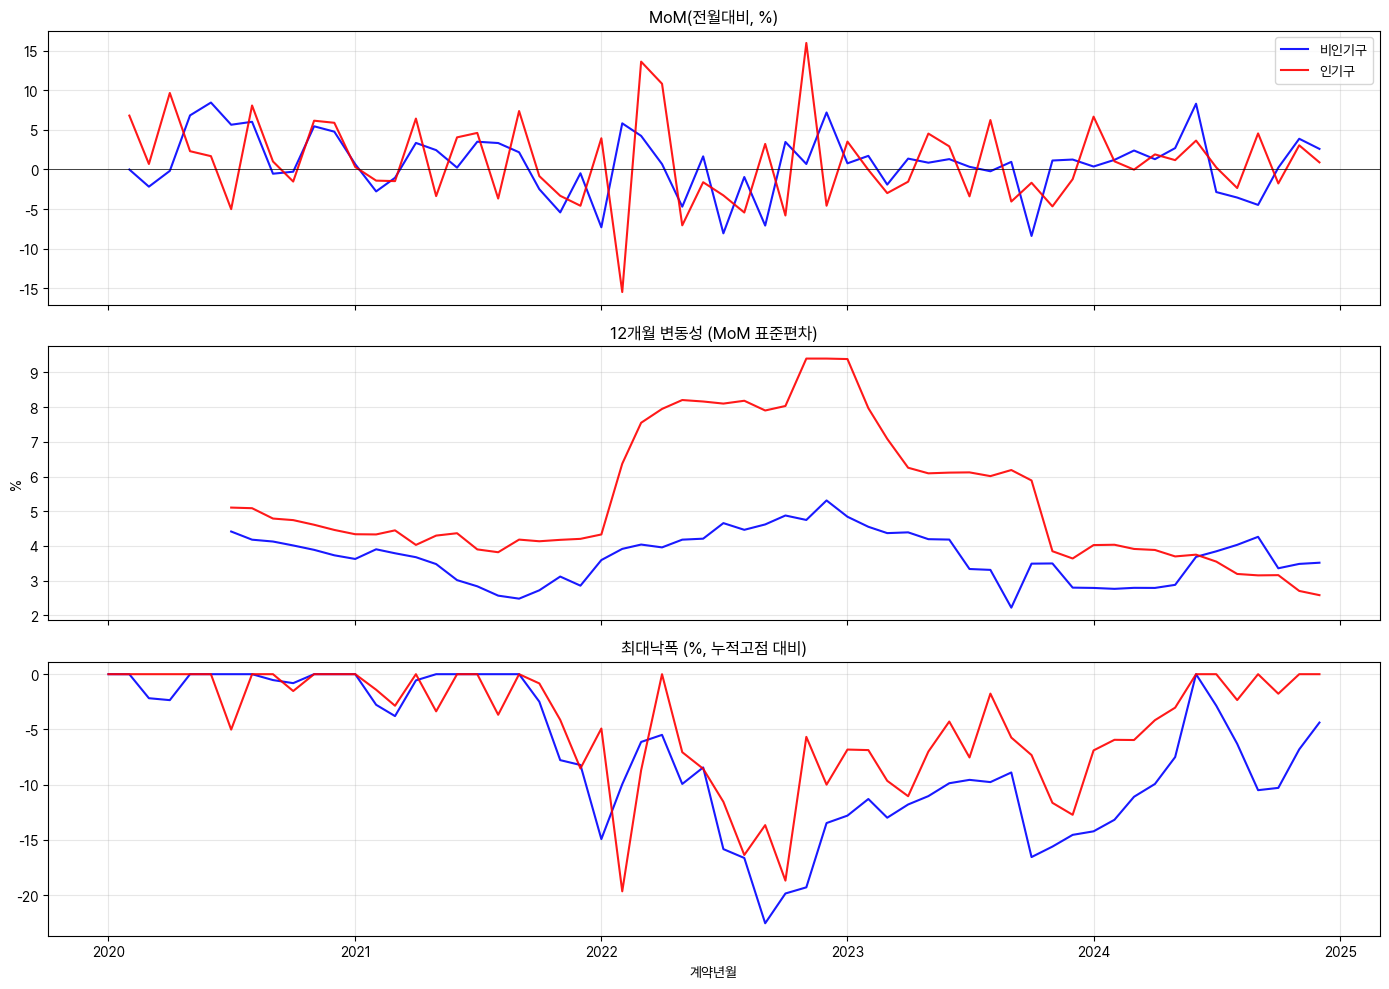

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 월×인기구 중위값
g = (df_all.groupby(['계약년월','인기구'])['평단가(만원)']
              .median().reset_index()).sort_values('계약년월')

# 집단별 계산 함수
def add_metrics(sub):
    sub = sub.sort_values('계약년월').copy()
    sub['MoM'] = sub['평단가(만원)'].pct_change() * 100
    sub['YoY'] = sub['평단가(만원)'].pct_change(12) * 100
    sub['Vol12M'] = sub['MoM'].rolling(12, min_periods=6).std()      # % 기준 표준편차
    peak = sub['평단가(만원)'].cummax()
    sub['Drawdown'] = sub['평단가(만원)']/peak - 1                    # -0.XX (비율)
    return sub

gg = g.groupby('인기구', group_keys=False).apply(add_metrics)

# 색상 고정
cmap = {1:'red', 0:'blue', '인기구':'red', '비인기구':'blue'}

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1) MoM (%)
for k, sub in gg.groupby('인기구'):
    axes[0].plot(sub['계약년월'], sub['MoM'], color=cmap.get(k,'gray'), label=('인기구' if k in [1,'인기구'] else '비인기구'), alpha=0.9)
axes[0].axhline(0, color='k', lw=0.5); axes[0].set_title('MoM(전월대비, %)'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

# 2) 변동성: 12M Rolling std of MoM
for k, sub in gg.groupby('인기구'):
    axes[1].plot(sub['계약년월'], sub['Vol12M'], color=cmap.get(k,'gray'), alpha=0.9)
axes[1].set_title('12개월 변동성 (MoM 표준편차)'); axes[1].set_ylabel('%'); axes[1].grid(True, alpha=0.3)

# 3) 최대낙폭 (누적고점 대비)
for k, sub in gg.groupby('인기구'):
    axes[2].plot(sub['계약년월'], sub['Drawdown']*100, color=cmap.get(k,'gray'), alpha=0.9)
axes[2].set_title('최대낙폭 (%, 누적고점 대비)'); axes[2].set_xlabel('계약년월'); axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

In [15]:
monthly_apt_price_comp  = df_all.groupby(['계약년월','인기구']).agg(
    평단가=('평단가(만원)', 'median'),
    거래량=('평단가(만원)', 'size')  # size는 해당 그룹 row 수 카운트
).reset_index()

display(monthly_apt_price_comp.head())
popular_mask = monthly_apt_price_comp['인기구']=='인기구'

monthly_apt = df_all.groupby(['계약년월','구']).agg(
    평단가=('평단가(만원)', 'median'),
    거래량=('평단가(만원)', 'size')  # size는 해당 그룹 row 수 카운트
).reset_index()


,계약년월,인기구,평단가,거래량
0,2020-01-01,비인기구,2543.66,5524
1,2020-01-01,인기구,4272.22,959
2,2020-02-01,비인기구,2543.54,6912
3,2020-02-01,인기구,4563.38,1339
4,2020-03-01,비인기구,2488.31,3617


In [26]:
# --- 지표 계산 함수 ---
def calc_metrics(df: pd.DataFrame) -> dict:
    df = df.sort_values("계약년월").copy()

    # CAGR
    start_val, end_val = df["평단가"].iloc[0], df["평단가"].iloc[-1]
    n_years = (df["계약년월"].iloc[-1].year - df["계약년월"].iloc[0].year) + \
              (df["계약년월"].iloc[-1].month - df["계약년월"].iloc[0].month)/12
    cagr = (end_val/start_val)**(1/n_years) - 1 if start_val > 0 else np.nan

    # 최근 12M YoY 평균
    df["YoY"] = df["평단가"].pct_change(12) * 100
    yoy_mean = df["YoY"].tail(12).mean()

    # 변동성 (전체 기간, 월간 수익률 표준편차 × √12)
    df["MoM"] = df["평단가"].pct_change()
    volatility = df["MoM"].std() * np.sqrt(12) * 100

    # 최대낙폭 (Drawdown)
    peak = df["평단가"].cummax()
    drawdown = (df["평단가"]/peak - 1).min() * 100

    # 거래량 증감률 평균 (YoY)
    df["거래량증감률"] = df["거래량"].pct_change(12) * 100
    vol_change_mean = df["거래량증감률"].mean()

    # 수익/위험 비율 = CAGR / 변동성
    sharpe_like = (cagr*100) / volatility if volatility > 0 else np.nan

    return {
        "CAGR(%)": round(cagr*100, 2),
        "최근12M YoY 평균(%)": round(yoy_mean, 2),
        "변동성(연율,%p)": round(volatility, 2),
        "최대낙폭(%)": round(drawdown, 2),
        "평균 거래량 증감률(%)": round(vol_change_mean, 2),
        "수익/위험 비율": round(sharpe_like, 2)
    }

# --- 집계 실행 ---
result = []
for g, sub in monthly_apt_price_comp.groupby("인기구"):
    result.append({"구분": g, **calc_metrics(sub)})

summary_table = pd.DataFrame(result).set_index("구분")
summary_table

,CAGR(%),최근12M YoY 평균(%),"변동성(연율,%p)",최대낙폭(%),평균 거래량 증감률(%),수익/위험 비율
구분,,,,,,
비인기구,8.54,4.69,13.25,-22.55,42.18,0.64
인기구,11.30,7.31,18.60,-19.66,64.22,0.61


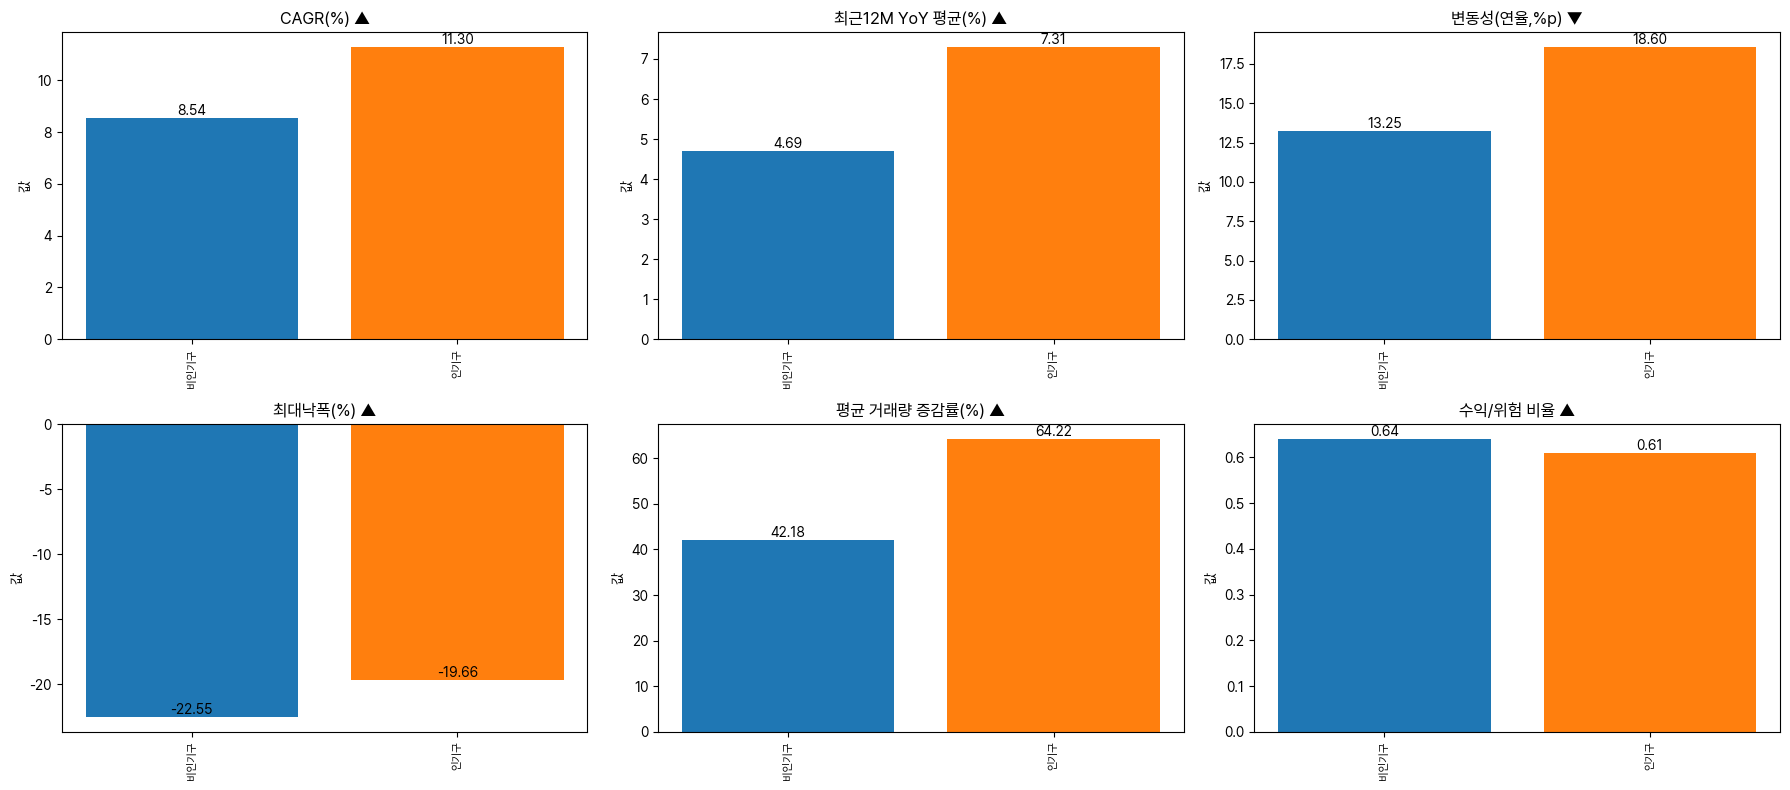

In [27]:
# 레이블명 + 방향 표시
labels = {
    "CAGR(%)": "CAGR(%) ▲",
    "최근12M YoY 평균(%)": "최근12M YoY 평균(%) ▲",
    "변동성(연율,%p)": "변동성(연율,%p) ▼",
    "최대낙폭(%)": "최대낙폭(%) ▲",
    "평균 거래량 증감률(%)": "평균 거래량 증감률(%) ▲",
    "수익/위험 비율": "수익/위험 비율 ▲"
}

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate([c for c in summary_table.columns if c != "시장매력도"]):
    ax = axes[i]
    values = summary_table[col].copy()

    # 거래량 증감률은 그래프는 양수화
    if col == "평균 거래량 증감률(%)":
        plot_vals = values.abs()
    else:
        plot_vals = values

    bars = ax.bar(summary_table.index, plot_vals, color=["#1f77b4", "#ff7f0e"])
    
    # 각 값 표시 (원래 값 유지)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height(), 
                f"{val:.2f}", 
                ha='center', va='bottom')

    ax.set_title(labels[col])
    ax.set_ylabel("값")
    ax.set_xticklabels(summary_table.index, rotation=90, fontsize=8)
    

plt.tight_layout()
plt.show()

In [28]:
def market_attractiveness(df: pd.DataFrame, mode="investor") -> pd.Series:
    df = df.copy()

    # 0~1 스케일화
    df["CAGR_norm"] = df["CAGR(%)"] / 100
    df["YoY_norm"] = df["최근12M YoY 평균(%)"] / 100
    df["거래량_norm"] = df["평균 거래량 증감률(%)"] / 100
    df["Sharpe_norm"] = df["수익/위험 비율"] / df["수익/위험 비율"].max()
    df["Drawdown_norm"] = abs(df["최대낙폭(%)"]) / 100
    df["Volatility_norm"] = df["변동성(연율,%p)"] / 100

    if mode == "investor":
        weights = {
            "CAGR_norm": 0.3,
            "YoY_norm": 0.2,
            "거래량_norm": 0.1,
            "Sharpe_norm": 0.25,
            "Drawdown_norm": -0.1,
            "Volatility_norm": -0.05,
        }
    elif mode == "policy":
        weights = {
            "CAGR_norm": 0.15,
            "YoY_norm": 0.1,
            "거래량_norm": 0.25,
            "Sharpe_norm": 0.1,
            "Drawdown_norm": -0.2,
            "Volatility_norm": -0.2,
        }
    else:
        raise ValueError("mode must be 'investor' or 'policy'")

    score = sum(df[k] * v for k, v in weights.items())
    return score.round(3)

# 사용 예시
summary_table["매력도(투자자)"] = market_attractiveness(summary_table, mode="investor")
summary_table["매력도(정책자)"] = market_attractiveness(summary_table, mode="policy")
summary_table

,CAGR(%),최근12M YoY 평균(%),"변동성(연율,%p)",최대낙폭(%),평균 거래량 증감률(%),수익/위험 비율,매력도(투자자),매력도(정책자)
구분,,,,,,,,
비인기구,8.54,4.69,13.25,-22.55,42.18,0.64,0.298,0.151
인기구,11.30,7.31,18.60,-19.66,64.22,0.61,0.322,0.204


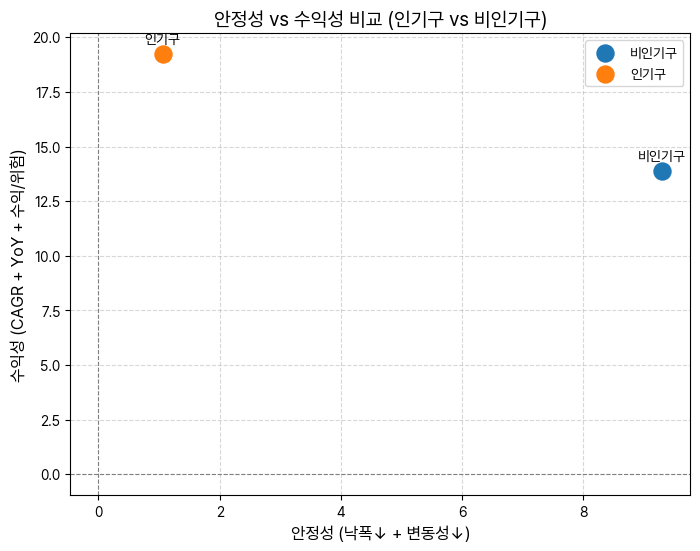

In [29]:
import matplotlib.pyplot as plt

# --- 안정성, 수익성 지표 합산 ---
summary_comp = summary_table.copy()

summary_comp["안정성"] = (-summary_comp["최대낙폭(%)"]) + (-summary_comp["변동성(연율,%p)"])
summary_comp["수익성"] = summary_comp["CAGR(%)"] + summary_comp["최근12M YoY 평균(%)"] + summary_comp["수익/위험 비율"]

# --- 스캐터 시각화 ---
plt.figure(figsize=(8,6))
for idx, row in summary_comp.iterrows():
    plt.scatter(row["안정성"], row["수익성"], label=idx, s=150)
    plt.text(row["안정성"], row["수익성"]+0.5, idx, ha='center')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.title("안정성 vs 수익성 비교 (인기구 vs 비인기구)", fontsize=14)
plt.xlabel("안정성 (낙폭↓ + 변동성↓)", fontsize=12)
plt.ylabel("수익성 (CAGR + YoY + 수익/위험)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### `2022년 급격한 부동산 가격 변화`

요약:
2022년 상반기 서울·수도권 아파트 평단가 상승 추세가 일시 소폭 후퇴한 주된 원인은 “한국은행의 공격적 기준금리 인상”과 “DSR/LTV 대출 규제 강화”가 실수요·투자 수요를 빠르게 위축시켰기 때문입니다. 여기에 “공급부족 우려 완화 조치” 등이 복합 작용하면서 매수 관망세가 심화되었습니다.

---

1. 한국은행 기준금리의 급격한 인상
	- 2022년 1월(1.25 %)→4월(1.50 %)→5월(1.75 %)→7월(2.25 %)→8월(2.50 %)까지 다섯 차례 인상하며 2011년 이후 최고 수준으로 올렸다  ￼.
	- 차입 비용 급등으로 주택담보대출 금리가 크게 상승하자 매수 심리가 즉각 위축됐다  ￼.

2. 대출 규제 강화 (DSR·LTV)
	- 2022년 1월부터 DSR(총부채원리금상환비율) 적용 대상의 총대출액 기준이 2억→7월 1억으로 강화돼 대출 한도가 큰 폭 축소됐다  ￼.
	- 2021년 하반기부터 단계 적용된 DSR 강화가 2022년 7월까지 총 세 차례에 걸쳐 이루어졌고, 이 기간 서울 아파트 매매가격 상승률이 단계 강화 시기마다 둔화됐다  ￼.

3. 정부의 시장 안정화 대책
	- 2022년 6월 28일 발표한 **‘부동산 정책방향’** 에서 전월세 세액공제 확대, 규제지역 전입의무 폐지 등 주택 공급·임대 지원책을 내놓아 잠시 매수 관망을 심화시켰다  ￼.
	- LH 토지주택연구원은 “2021년 하반기 금융권 대출규제와 금리 인상 여파로 2022년 상반기까지 약보합세를 기록”했다고 분석했다  ￼.

4. 시장 심리 및 수요 관망
	- KDI 보고서는 “수도권 주택가격지수는 2분기(2022 Q2) 전분기 대비 0.05% 하락하며 매수 관망세가 심화됐다”고 전했다  ￼.
	- 부동산R114 설문 조사에서 **절반 이상(50 %)** 가 “대출 규제·금리 인상으로 매수세가 악화될 것”이라 답해 수요 위축 기대가 뚜렷해졌다  ￼.
	- K-REMAP 지수 등 소비자 심리지표도 2022년 상반기 들어 크게 하락하며 매매·전세 모두 ‘관망’ 지표를 기록했다  ￼.

---

결론
> 	- 금리 인상과 DSR 강화가 핵심.
>	- 정부 지원책 발표로 매수 관망 심화.
>	- 수요 심리 저하가 시장 조정 기간을 연장시켰다.

이 네 가지 국내 요인이 복합적으로 작용해 2022년 상반기 상승 추세가 일시 흔들린 뒤, 하반기 들어 다시 상승 흐름으로 전환되었습니다.

---

참고 문헌
1. 한국은행 기준금리 추이  ￼
2.	금통위 ‘숨 고르기’ 동결 배경  ￼
3.	DSR 규제 강화 방안  ￼
4.	DSR 단계별 적용 효과  ￼
5.	2022년 부동산 정책방향(MOEF)  ￼
6.	LH 주택시장 동향 분석  ￼
7.	KDI 2022년 2/4분기 부동산 동향  ￼
8.	부동산R114 수요 전망  ￼
9.	K-REMAP 시장 심리지표  ￼
10.	MOEF 정부 대책 발표(6/28)  ￼

# 2번 과제

### 규모구분 컬럼 추가

In [30]:
df_all

,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도,규모구분,인기구
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,2020-12-01,3184.28,2020,중형,비인기구
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,2020-12-01,9750.11,2020,대형,인기구
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,2020-12-01,6998.11,2020,중형,인기구
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,2020-12-01,1884.00,2020,대형,비인기구
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,2020-12-01,5246.11,2020,중형,인기구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,2024-01-01,6464.65,2024,소형,비인기구
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,2024-01-01,5792.54,2024,중형,인기구
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",2024-01-01,5505.51,2024,소형,인기구
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,2024-01-01,2252.82,2024,중형,비인기구


In [31]:
df_all.groupby(['연도', '규모구분'])['거래금액(만원)'].mean().round(2).unstack()

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_10699/3886984882.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all.groupby(['연도', '규모구분'])['거래금액(만원)'].mean().round(2).unstack()


규모구분,소형,중형,대형
연도,,,
2020,58960.33,88835.61,138930.02
2021,68090.38,109867.55,187649.51
2022,54689.91,114270.65,219142.54
2023,72128.37,113879.22,194362.21
2024,80153.13,124324.05,217134.55


/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_10699/737050573.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = getattr(dfc.groupby(['년월', size_col])[price_col], agg_func)().reset_index()


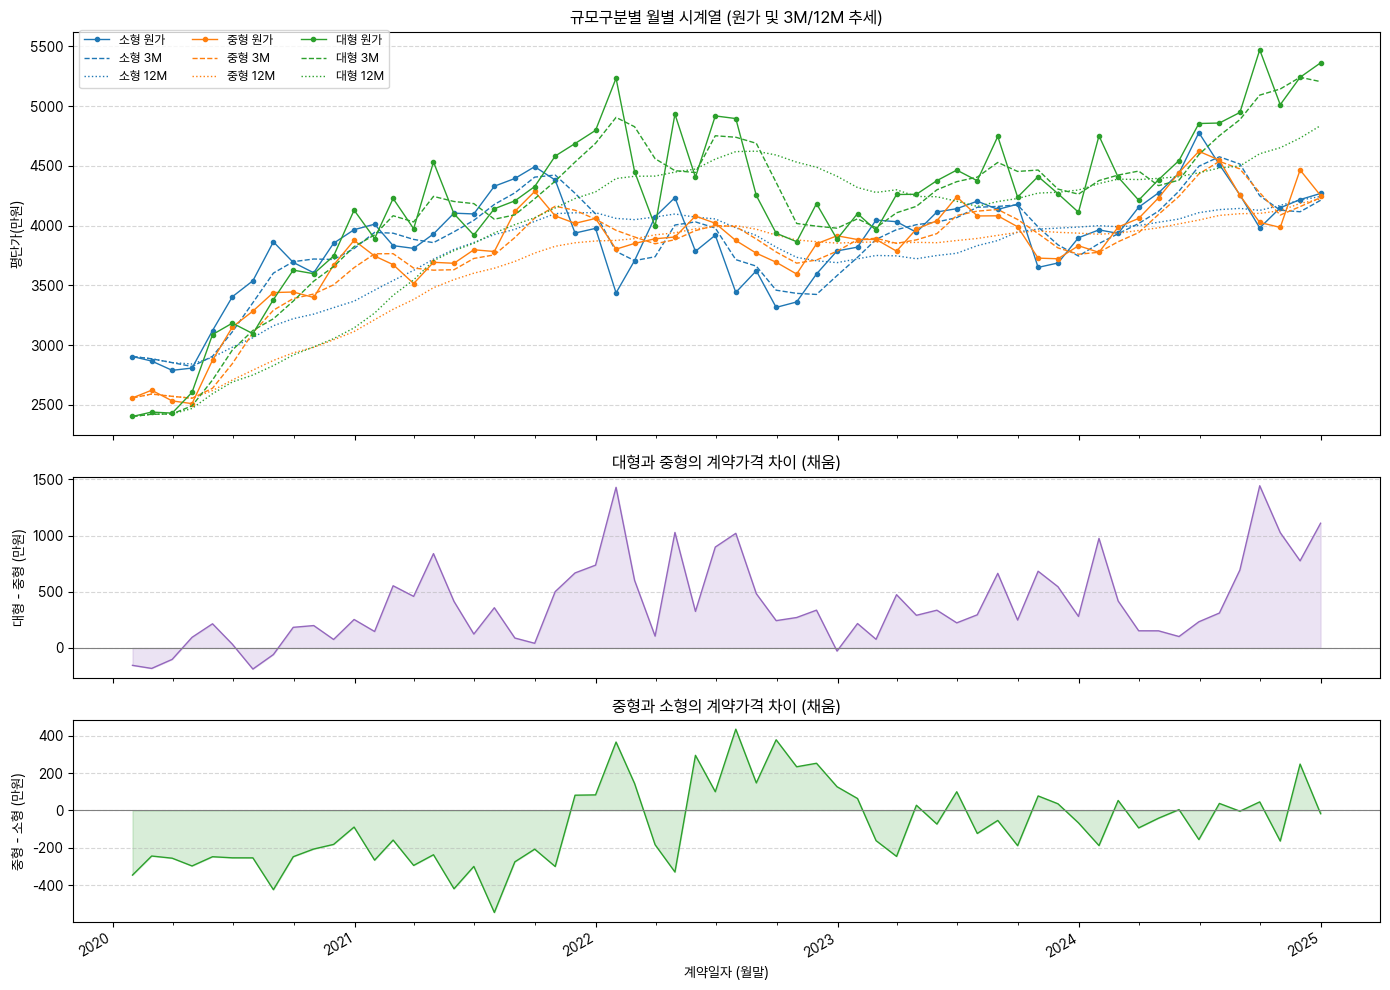

In [24]:
import matplotlib.dates as mdates

def plot_size_trends_subplots(df,
                              date_col='계약일자',
                              size_col='규모구분',
                              price_col='평단가(만원)',
                              agg_func='median'):
    """
    1) 전체(소/중/대) 월별 시계열 + 3M/12M 추세
    2) 대형 - 중형 차이 (채움, 추세선 없음)
    3) 중형 - 소형 차이 (채움, 추세선 없음)
    """
    dfc = df.copy()
    dfc[date_col] = pd.to_datetime(dfc[date_col])
    # 월말 인덱스
    dfc['년월'] = dfc[date_col].dt.to_period('M').dt.to_timestamp('M')
    agg = getattr(dfc.groupby(['년월', size_col])[price_col], agg_func)().reset_index()
    ts = agg.pivot(index='년월', columns=size_col, values=price_col).sort_index()

    # 기대하는 컬럼명 체크
    expected = ['소형','중형','대형']
    missing = [c for c in expected if c not in ts.columns]
    if missing:
        raise ValueError(f"규모구분 컬럼에 다음 레이블이 필요합니다: {expected}. 누락: {missing}")

    ma3  = ts.rolling(window=3, min_periods=1).mean()
    ma12 = ts.rolling(window=12, min_periods=1).mean()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios':[2,1,1]})

    cmap = plt.get_cmap('tab10')
    colors = {'소형': cmap(0), '중형': cmap(1), '대형': cmap(2)}

    # 1) 수준 + 추세
    for i, col in enumerate(['소형','중형','대형']):
        ax1.plot(ts.index, ts[col], marker='.', linewidth=1, label=f'{col} 원가', color=colors[col])
        ax1.plot(ma3.index, ma3[col], linestyle='--', linewidth=1, label=f'{col} 3M', color=colors[col])
        ax1.plot(ma12.index, ma12[col], linestyle=':', linewidth=1, label=f'{col} 12M', color=colors[col])
    ax1.set_ylabel(price_col)
    ax1.set_title('규모구분별 월별 시계열 (원가 및 3M/12M 추세)')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    # 범례 중복 제거
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), ncol=3, fontsize=9, loc='upper left', bbox_to_anchor=(0,1.02))

    # 2) 대형 - 중형 차이 (채움)
    diff_lm = ts['대형'] - ts['중형']
    ax2.plot(diff_lm.index, diff_lm.values, color='tab:purple', linewidth=1)
    ax2.fill_between(diff_lm.index, 0, diff_lm.values, where=~pd.isna(diff_lm.values),
                     interpolate=True, color='tab:purple', alpha=0.18)
    ax2.axhline(0, color='gray', linewidth=0.8)
    ax2.set_ylabel('대형 - 중형 (만원)')
    ax2.set_title('대형과 중형의 계약가격 차이 (채움)')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    # 3) 중형 - 소형 차이 (채움)
    diff_ms = ts['중형'] - ts['소형']
    ax3.plot(diff_ms.index, diff_ms.values, color='tab:green', linewidth=1)
    ax3.fill_between(diff_ms.index, 0, diff_ms.values, where=~pd.isna(diff_ms.values),
                     interpolate=True, color='tab:green', alpha=0.18)
    ax3.axhline(0, color='gray', linewidth=0.8)
    ax3.set_ylabel('중형 - 소형 (만원)')
    ax3.set_title('중형과 소형의 계약가격 차이 (채움)')
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # x축 포맷 (연도 라벨)
    ax3.xaxis.set_major_locator(mdates.YearLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
    fig.autofmt_xdate()
    ax3.set_xlabel('계약일자 (월말)')

    plt.tight_layout()
    plt.show()
plot_size_trends_subplots(df_all)

생애주기별 아파트 규모 전략 보고서

(데이터 기반 요약 · 2020–2024 시계열 분석 기준)

---

1. 요약 결론
	•	금리 민감도: 대형 > 중형 > 소형. 금리 상승기에는 대형의 낙폭이 가장 크고 회복 역시 빠름.
	•	규모별 특성: 대형은 장기적 프리미엄 및 변동성, 중형은 안정적 완충 역할, 소형은 유동성·임대수요 기반의 방어력 보유.
	•	정책(금리) 연계 인사이트: 2021후반~2022 연속 금리 인상 구간에서 대형 선행 하락·격차 일시 축소, 2023 이후 금리 정체·완화 기대 국면에서 대형 선행 회복 및 격차 재확대 관찰.

---

2. 데이터 기반 관찰 (핵심 포인트)
	•	월별 원가 및 3M/12M 이동평균 분석 결과:
	•	대형: 평균 수준 가장 높고, 3M MA의 변동성이 큼. 대형−중형 차이는 대체로 양수이며 2020→2024 기간에 확장 경향.
	•	중형: 수준과 지수에서 중립적 위치. 12M MA가 매끄러워 방어적 성격이 뚜렷함.
	•	소형: 중형 대비 상대적 견조 또는 초과 수요 구간 존재. 유동성·임대 수요에 강함.
	•	차이(대형−중형, 중형−소형) 시계열:
	•	대형 프리미엄(대형−중형)이 확대된 구간에서 장기 자본 이득 가능성 높음.
	•	중형−소형 차이가 음수로 지속되는 구간은 소형의 상대 강세를 의미.

---

3. 생애주기별 권장 전략 (정책·금리 맥락 포함)

A. 초기(20대·싱글, 유동성·유연성 우선)
	•	권장 규모: 소형.
	•	이유: 임대·전세 수요가 높아 유동성 확보 용이. 금리 상승기에도 상대적 방어력 보유.
	•	운용 전략: 레버리지 보수적. 임대수익(월세·전세) 중심 단기 보유.

B. 성장기(30대, 결혼·자녀계획, 중기 거주)
	•	권장 규모: 중형.
	•	이유: 생활 공간과 자산 성장의 균형. 금리 변동에 대한 완충 역할 유리.
	•	운용 전략: 거주 우선, 필요시 소형 일부로 임대수익 보강.

C. 성숙기(40대, 자산 증식 목표)
	•	권장 규모: 대형 또는 입지 좋은 중형.
	•	이유: 대형의 장기 프리미엄·자본증식 잠재력. 금리 완화·상승 사이클 확인 후 포지셔닝 권장.
	•	운용 전략: 금리 하향 전환(또는 3M>12M 교차 등 추세 신호) 시 대형 비중 확대. 금리 급등 시 리스크 축소.

D. 은퇴기(자본보호·현금흐름 우선)
	•	권장 규모: 소형 혹은 중형(유지비·현금흐름 고려).
	•	이유: 현금화·월세 전환 용이. 변동성·관리비 낮음.
	•	운용 전략: 현금흐름 안정화 중심. 레버리지 최소화.

---

4. 투자·매매 규칙 (데이터 신호 기반)
	•	추세 교차(매수/매도 신호)
	•	매수(대형): 대형의 3M MA가 12M MA를 상향 교차하고 대형 − 중형이 확대 추세일 때.
	•	매도(대형 감축): 3M MA가 12M MA를 하향 교차하거나 기준금리 급등(단기) 신호 발생 시.
	•	상대가치 룰
	•	비율(하위/상위) 또는 gap_LM = 대형 − 중형 임계값 기반 리밸런싱(예: gap_LM 과거 분포 상위 10%/하위 10% 사용).
	•	금리 연동 규칙
	•	기준금리 상승(연속적 인상) 국면: 대형 비중 감축, 중형 비중 유지 또는 확대.
	•	기준금리 하향·완화 기대: 대형 선행 회복 → 대형 비중 확대 고려.

---

5. 모니터링 지표(우선 구축 권장)
	•	규모별: 월별 median 평단가, 3M MA, 12M MA.
	•	격차: gap_LM = 대형 − 중형, gap_MS = 중형 − 소형.
	•	비율: 하위/상위(또는 소형/대형 대비비).
	•	금리: 기준금리(계단형, 변경월 즉시 반영).
	•	신호: MA 교차, gap 임계(예: 과거 90/10 퍼센타일), 금리 변곡 시점.

---

6. 금리 변동과 연계된 핵심 인사이트
	1.	금리 인상기(예: 2021후반→2022):
	•	대형이 선행해서 하락. 레버리지·자금조달 민감도가 크기 때문.
	•	결과적으로 대형−중형 격차 일시 축소. 투자자 관점에서는 대형의 리스크가 빠르게 확대됨.
	2.	금리 정체·완화 기대(예: 2023 이후~2024 완만 반등):
	•	대형이 선도적으로 회복하며 프리미엄 확대. 금리 완화는 레버리지 해소와 수요 재유입을 촉발함.
	3.	운용 시사점:
	•	금리 방향성은 규모별 포지셔닝의 우선적 결정요인. 금리 상승·불확실기에는 중형·소형 비중 확대. 금리 완화 및 추세 전환 시 대형 비중 확대 검토.
---

7. 실행 체크리스트 (우선순위)
	1.	월별 시계열로 median 평단가, 3M/12M MA, gap_LM, gap_MS, 기준금리 계산.
	2.	단순 룰(예: MA 교차, gap 임계)로 백테스트(성과·최대낙폭) 수행.
	3.	실제 포트폴리오 적용 전 거래비용·세제 영향 시나리오 반영.
	4.	정기 리포트: 월별 지표·신호 요약(대시보드 자동화 권장).

---

8. 결론
	•	데이터는 대형의 고수익·고리스크, 중형의 완충, 소형의 유동성·임대 우위라는 명확한 구조를 지지한다.
	•	정책·금리 사이클을 신호로 삼아 규모별 비중을 탄력적으로 운용하는 것이 합리적이다.
	•	제안한 모니터링 지표와 간단한 룰을 먼저 구현한 뒤 백테스트로 규칙을 검증하면 실무 적용 가능성이 높아진다.